# 04 - Applied ML

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.optimize import linear_sum_assignment

import seaborn as sns
import networkx as nx
%matplotlib inline
import matplotlib.patches as mpatches

# Question 1
## 1. A naive analysis

First, we load our data and have a look at its contents.

In [2]:
data = pd.read_csv('lalonde.csv')
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Now, we will try to compare the distribution of the feature `re78` (i.e. the real earnings in 1978) between the two groups. To do so, we first use the `DataFrame.describe` function on both groups.

In [3]:
# Separate treated and untreated people
data_treated = data[data["treat"] == 1]
data_untreated = data[data["treat"] == 0]

data_treated[['re78']].describe()

,re78
count,185.000000
mean,6349.143530
std,7867.402218
min,0.000000
25%,485.229800
50%,4232.309000
75%,9642.999000
max,60307.930000


In [5]:
data_untreated[['re78']].describe()

,re78
count,429.000000
mean,6984.169742
std,7294.161791
min,0.000000
25%,220.181300
50%,4975.505000
75%,11688.820000
max,25564.670000


In order to get more insight a visualize these numbers better, we create a helper function that plots the histogram and boxplot for both groups. This function is very useful as it will be reused several times later on.

In [6]:
def plot_feature_hist(feature_name, data, legend_side='right'):
    """Display, for the given feature, two histograms on top of each other representing 
       the distribution of respectively the treated and untreated groups, as well as a 
       boxplot of both groups.
    
    feature_name: name of the feature to be plotted
    data: data on which the plots should be based
    legend_side: side on which the legend should be displayed ('left', 'right', or 'center')
    """
    
    # Compute the minimum and maximum value to set the scale of the histogram
    r_min = data[feature_name].min()
    r_max = data[feature_name].max()
    
    # Separate treated and untreated people
    data_treated = data[data["treat"] == 1]
    data_untreated = data[data["treat"] == 0]
    
    # Create plots
    plt.figure(figsize=(14,5))
    plt.suptitle(feature_name, fontsize=18)
    ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    
    # Plot two histograms for treated and untreated groups
    ax1.hist(data_treated[feature_name], normed=True, bins=30, range=(r_min, r_max), color='blue', alpha=0.7)
    ax1.hist(data_untreated[feature_name], normed=True, bins=30, range=(r_min, r_max), color='orange', alpha=0.7)
    
    # Add legend
    treated_patch = mpatches.Patch(color='blue', label='Treated subjects')
    untreated_patch = mpatches.Patch(color='orange', label='Untreated subjects')
    both_patch = mpatches.Patch(color='#c68750', label='Both')
    ax1.legend(handles=[treated_patch, untreated_patch, both_patch], loc='upper '+legend_side, prop={'size': 12})
    #ax1.legend(['Treated subjects', 'Untreated subjects', 'Both'], loc='upper '+legend_side, prop={'size': 12})
    
    # Add x-axis label
    plt.xlabel(feature_name)
    
    # Plot a boxplot for both groups next to the histogram
    ax2 = plt.subplot2grid((1, 3), (0, 2))
    box = ax2.boxplot([data_treated[feature_name], data_untreated[feature_name]], patch_artist=True, sym='k.')
    
    # Set edge color
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(box[element], color='black')
    plt.setp(box['medians'], color='white')
    
    # Set fill color of the boxplots
    for patch, color in zip(box['boxes'], ['blue', 'orange']):
        patch.set_facecolor(color)
    
    # Rename the ticks of the x axis
    plt.xticks([1, 2], ['Treated subjects', 'Untreated subjects'])
    
    plt.show()

Now let's use this function to display the distribution of `re78`.

C:\Users\bruno\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


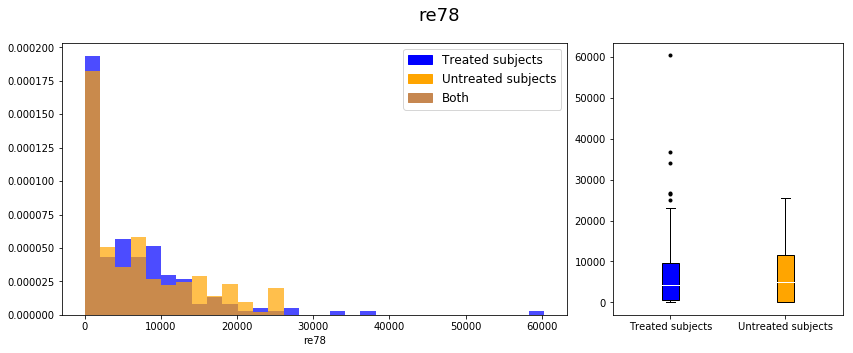

In [7]:
plot_feature_hist('re78', data)

When we look at the data only using this naive approach, we can be tempted to say that this treatment has no effect. Indeed, from this superficial analysis, the distribution of `re78` seems very similar for both groups, thus the logical conclusion for a naive researcher would be to say that the treatment had no effect.

## 2. A closer look at the data

Now, we will compare the distribution of each feature between the two groups and thus determine how well the treated group matches with the control group. As our dataset contains both continuous and binary features, we will deal with them separately, as different types of visualization arre needed to describe them.

### Analyzing continuous features
First, we will compare the difference in distibution of the continuous features. For this, we can conveniently reuse the function defined in the first part.

C:\Users\bruno\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


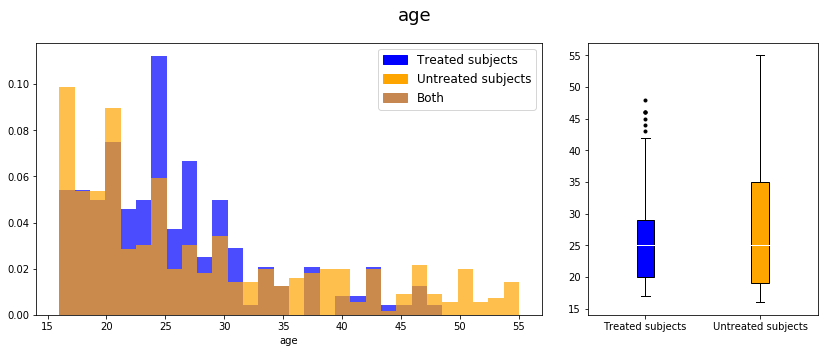

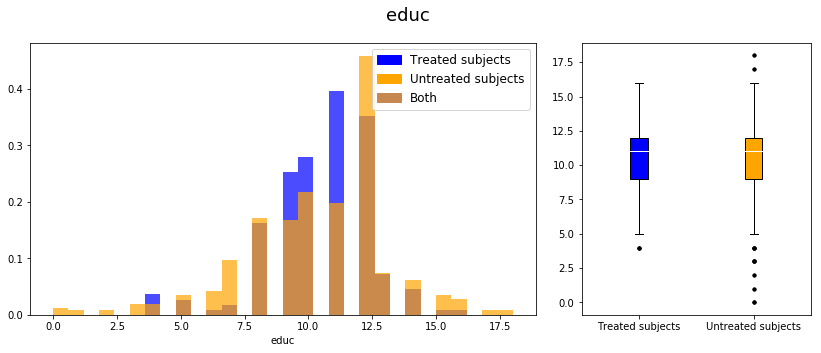

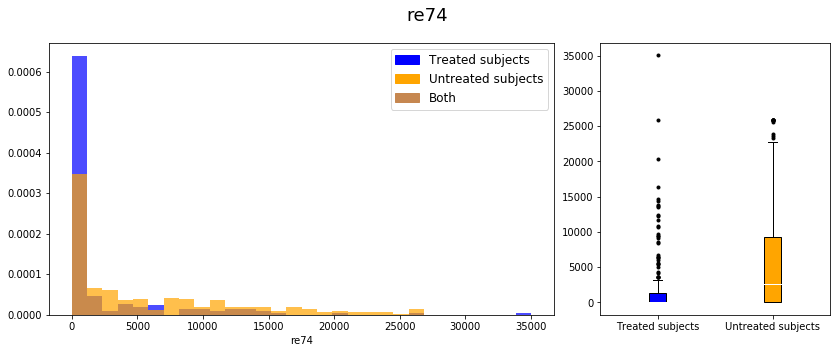

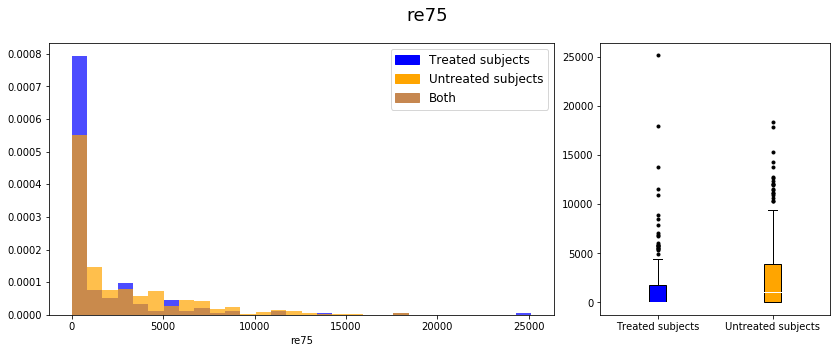

In [8]:
# Display histogram plots for continuous features
cts_features = ["age", "educ", "re74", "re75"]
for col in cts_features:
    plot_feature_hist(col, data)

We can observe from the plots above that the distribution is not very similar for most features. People from the control group seem to be a bit older than the treated group. Moreover, both the revenues in 1974 and 1975 seem to be higher for the control group. But on the contrary, the education seem to be quite similar between the two groups

### Analyzing binary features

Now, we will compare the difference in distibution of the binary features. First, we notice that the data doesn't have a specific feature that denotes if people are white. As we know from the README file that each subject is either Black, Hispanic or White, we add this feature to our dataset using the fact that a person is white if he/she is not Black nor Hispanic.

In [9]:
data['white'] = ((1-data['black']) & (1-data['hispan']))
data.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,1


Now, we can plot each binary feature in a single bar plot. We create a function to display this plot as we will use it several times later on.

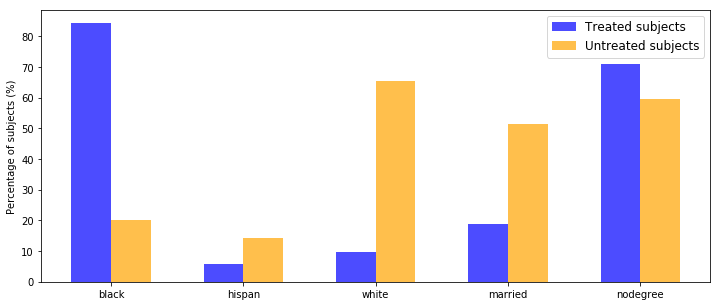

In [10]:
def plot_binary_features(data):
    binary_features = ['black', 'hispan', 'white', 'married', 'nodegree']

    # Separate treated and untreated people
    data_treated = data[data["treat"] == 1]
    data_untreated = data[data["treat"] == 0]

    # Get total number of subjects in both groups
    nb_subjects_treated = data_treated.shape[0]
    nb_subjects_untreated = data_untreated.shape[0]

    # Compute the percentage of each binary feature in both groups
    percentage_treated = [(100*data_treated[name].value_counts()[1] / nb_subjects_treated) for name in binary_features]
    percentage_untreated = [(100*data_untreated[name].value_counts()[1] / nb_subjects_untreated) for name in binary_features]

    # Create bar plots
    fig, ax = plt.subplots(figsize=(12,5))

    # Parameters for the width and position of the bars
    width = 0.3
    left = [i for i in range(len(percentage_treated))]

    # Plot bars for treated subjects
    plt.bar(left, percentage_treated, width=width, alpha=0.7, color='blue')
    # Plot bars for untreated subjects
    plt.bar([l + width for l in left], percentage_untreated, width=width, alpha=0.7, color='orange')

    ax.set_ylabel('Percentage of subjects (%)')

    # Set the labels and position of the ticks on the x-axis
    ax.set_xticklabels(binary_features)
    ax.set_xticks([p + width/2 for p in left])

    # Add legend and display the plot
    plt.legend(['Treated subjects', 'Untreated subjects'], loc='upper right', prop={'size': 12})
    plt.show()
    
plot_binary_features(data)

We can observe that the distribution of these features are quite different between the two groups. The biggest difference is the proportion of black and white people, with the treated group having proportionally about 4 times more black people, while the control group has about 5.5 times more white people. There is also a larger proportion of married people, as well as hispanic people in the control group. Finally, there is marginally a large percentage of people without a degree in the treated group.

### Conclusions
What we observe with the plots above is that the population of the treatement group and the population of the control group are very different. Therefore, a superficial analysis that draws conclusions without taking these differences into account will inevitably be biased. A less naive analysis is thus needed in order to generate more precise results.

## 3. A propsensity score model

As mentioned in the README, the propensity score of a subject is the probability of receiving the treatment, based on its pre-treatment features (i.e. age, education, pre-treatment income, etc). In order to compute those values, we use `sklearn` to fit a logistic regression model and apply it to each subject.

In [11]:
# The features vector
data_features = ["age", "educ", "re74", "re75", 'black', 'hispan', 'white', 'married', 'nodegree']
X = data[data_features]

# The label vector
y = data['treat']

# Fit logistic regression model
logistic = LogisticRegression()
logistic.fit(X, y)

# Get propsensity score from the model
pred_prob = logistic.predict_proba(X)
pred_prob

array([[ 0.48723672,  0.51276328],
       [ 0.7061392 ,  0.2938608 ],
       [ 0.35144998,  0.64855002],
       ..., 
       [ 0.88237872,  0.11762128],
       [ 0.4383438 ,  0.5616562 ],
       [ 0.84972247,  0.15027753]])

As we can see, the function `logistic.predict_proba(X)` gives for each subject the probability that he/she didn't receive the treatment and that he/she did receive the treatment, in that order. For the propensity score, we are thus interested in the latter probability

In [33]:
prop_score = pred_prob[:,1]
#adding the propsensity to data, will be useful later
data["propsensity"] = prop_score

Now, let us plot the distribution of the propensity score for both groups. For this, we reuse our handy `plot_feature_hist` function.

C:\Users\bruno\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


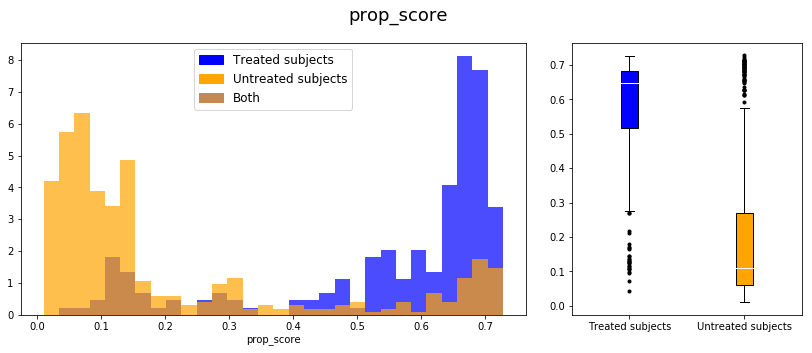

In [13]:
prop_score_df = pd.DataFrame.from_items([('prop_score', prop_score)])
prop_score_df['treat'] = data['treat']
plot_feature_hist('prop_score', prop_score_df, legend_side='center')

### Observations
From this histogram, we observe that in general the treated subjects have a higher propensity score than the untreated subjects. This indicates that our groups are biased, because our logistic regression model can actually predict quite well whether a given subject was treated based on the pre-treatment features alone. This means that by doing a naive analysis, our result could depend more on the pre-treatment characteristics of the two groups rather than on the treatment itself, which is obviously not desirable.

## 4. Balancing the dataset via matching

In order to reduce the bias induced by our groups, we want to make sure that both groups have more similar characteristics. This can be done by propensity score matching , i.e. matching pairs with one subject of each group according to the their propensity score, and then removing subjects that were not matched.

More specifically, our goal is to find matching pairs of a treated and untreated subjects such that the absolute propensity-score differences between the two matched subjects is minimized. As hinted in the README, the `networkx` package provides a hepful function, namely `max_weight_matching(G, maxcardinality=False)`, which computes a maximum-weighted matching of the undirected graph G. From the `networkx` documentation, we learn the following: 

> A matching is a subset of edges in which no node occurs more than once. The cardinality of a matching is the number of matched edges. The weight of a matching is the sum of the weights of its edges.

Therefore, in order to solve our problem by using this function, we must create a graph that has one node for each subject and edges from every treated subject nodes to every untreated subject nodes. With this setup, a minimum matching on this graph is equivalent to selecting a set of pairs of one treated and one untreated subject. The edges of the matching thus correspond to the selected pairs.

The last thing we have to decide is how to set the weights of the edges of our graph so that the absolute propensity-score differences between matched subjects is minimized. Since the function maximizes the weight, we set the edge weights as the the negative of the absolute propensity-score differences. We still have to set the parameter `maxcardinality` to `True` so that the maximum number of edges (i.e. subject pairs) are matched.

In [14]:
# Create the graph
G = nx.graph.Graph()
    
# Create a node for each subject
for index in data.index:
    G.add_node(index)

# Get the indices of the treated and untreated subjects
treated_idx = np.where(data['treat'] == 1)[0]
untreated_idx = np.where(data['treat'] == 0)[0]
    
# Create edges between each treated and untreated subjects
for t_index in treated_idx:
    for unt_index in untreated_idx:
        # Set the weight as the absolute propensity-score difference
        abs_diff = np.abs(prop_score[t_index] - prop_score[unt_index])
        G.add_edge(t_index, unt_index, weight=-abs_diff)

In [15]:
# Compute maximum weight matching to get pairs
matching = nx.max_weight_matching(G, maxcardinality=True)

In [16]:
# Retrieve the ids and the data of the matched subjects
matched_idx = list(matching.keys())
matched_data = data.iloc[matched_idx,:]

Now we can compare the distribution of `re78` between the two groups using the matched subjects only.

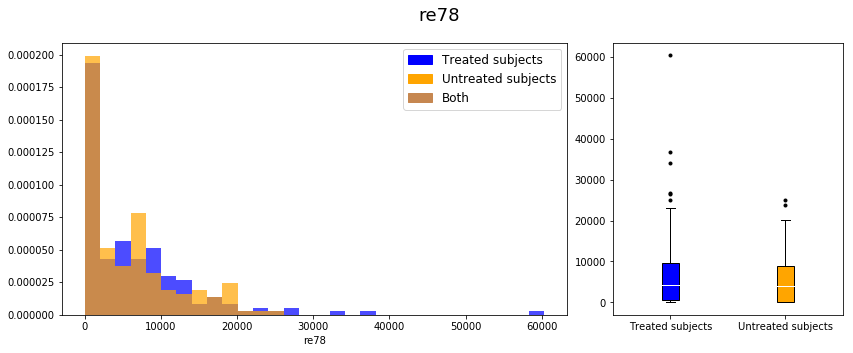

In [17]:
# Plot re78 for the matched data
plot_feature_hist("re78", matched_data)

We can observe now that the revenue for untreated subjects is generally a little smaller than without matching.

Let us now compare the distribution of the pre-treatment features.

### Continuous features

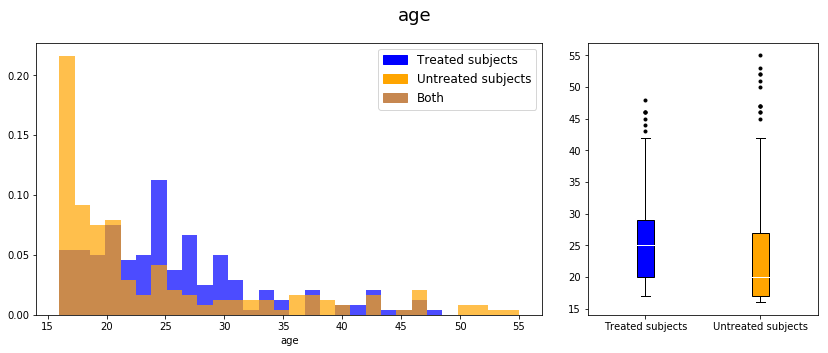

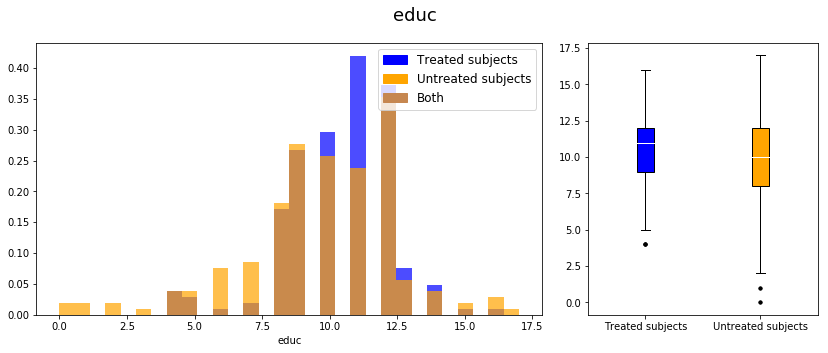

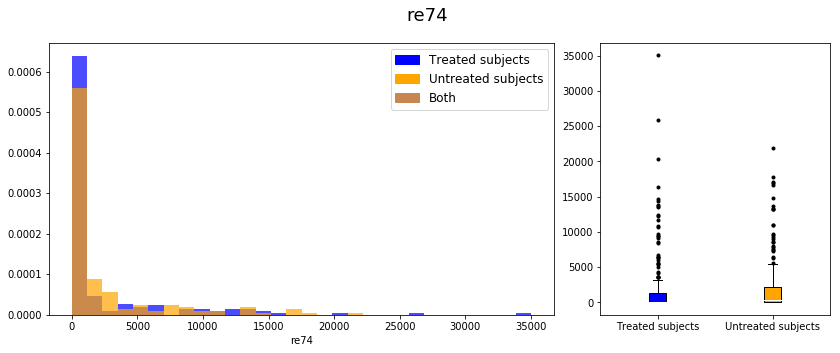

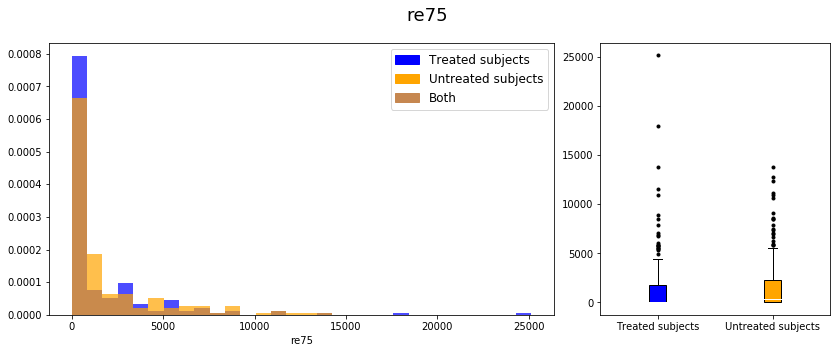

In [18]:
# Plot continuous features
for col in cts_features:
    plot_feature_hist(col, matched_data)

Comparing this with the plots made in part 2, we see that these features are now much more even between the two groups. The most change we see is for the `re74` feature, where the revenues of the control group was significantly lowered after the matching.

### Binary features

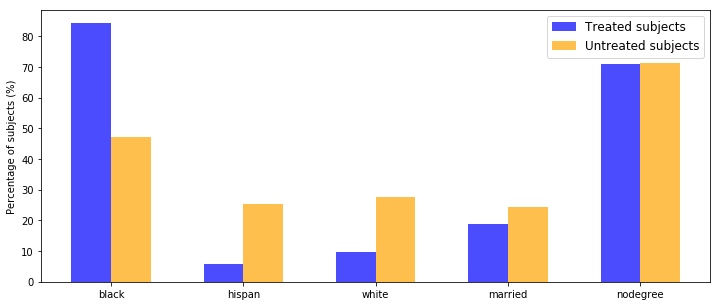

In [19]:
# Plot binary features
plot_binary_features(matched_data)

Again, these features are in general much more balanced than before. The `nodegree` feature is now almost perfectly balanced, while the `black`, `white`, and `married` also saw significant improvement. Only the `hispan`feature seem to have gotten a little worse after matching. 

The two groups have now more similar characteristics, but it is still not optimal, as there are aproximately 30% more black people in the treated group. Moreover the proportion of Hispanic people and White people is still not so well balanced. Thus, the distribution of the different ethnicities in bothe group could be improved.

## 5. Balancing the groups further

We notice just below that the black feature does not balance well enough, because there are more treated ones than control ones, making it difficult to draw valid conclusion on the treatement. We will explicitly match only if this feature matches.

In [68]:
# recompute treated and untreated data because we need the "white" column
data_treated = data[data["treat"] == 1]
data_untreated = data[data["treat"] == 0]

treat_white_df = data_treated[data_treated["white"]==1].reset_index(drop=True)
treat_black_df = data_treated[data_treated["black"]==1].reset_index(drop=True)
treat_hispanic_df = data_treated[data_treated["hispan"]==1].reset_index(drop=True)

control_white_df = data_untreated[data_untreated["white"]==1].reset_index(drop=True)
control_black_df = data_untreated[data_untreated["black"]==1].reset_index(drop=True)
control_hispanic_df = data_untreated[data_untreated["hispan"]==1].reset_index(drop=True)


print(treat_white_df.shape, control_white_df.shape)
print(treat_black_df.shape, control_black_df.shape)
print(treat_hispanic_df.shape, control_hispanic_df.shape)

(18, 13) (281, 13)
(156, 13) (87, 13)
(11, 13) (61, 13)


We will have to reduce the group of black treated people to 87 to be sure to find a match to any of them

Here we have a helper function to match each treated person to a control person.

In [69]:
def match(treat_df, control_df):
    
    #store in prop_treat, prop_control the vectors of the propensity scores of groups
    prop_treat = treat_df['propsensity']
    prop_control = control_df['propsensity']
    
    # building the matrix of costs of the arches of the bipartite graph
    cost = np.array([np.abs(p-prop_control) for p in prop_treat])
    
    #find the matches
    row_ind, col_ind = linear_sum_assignment(cost)
    
    #extract the matched people from treatment and control group
    matched_treat_df = treat_df.loc[row_ind]
    matched_control_df = control_df.loc[col_ind]
    #add a new feature to the treatment: the ID of the matched person in the control group
    matched_treat_df['matched control ID']=col_ind
    #merge the dataframe, to have the data of the matched people on the same row!
    merged_df = pd.merge(matched_treat_df, matched_control_df, left_on='matched control ID', right_index=True)
    
    
    merged_df['RESULT OF TREATMENT']=(merged_df.re78_x-merged_df.re74_x)-\
                                     (merged_df.re78_y-merged_df.re74_y)
    
    return matched_treat_df,matched_control_df, merged_df



In [70]:
treat_white_df, control_white_df, merged_white_df = match(treat_white_df, control_white_df)
treat_black_df, control_black_df, merged_black_df = match(treat_black_df, control_black_df)
treat_hispanic_df, control_hispanic_df, merged_hispanic_df = match(treat_hispanic_df, control_hispanic_df)


print(treat_white_df.shape, control_white_df.shape)
print(treat_black_df.shape, control_black_df.shape)
print(treat_hispanic_df.shape, control_hispanic_df.shape)
treat_white_df.head()

(18, 14) (18, 13)
(87, 14) (87, 13)
(11, 14) (11, 13)


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,propsensity,matched control ID
0,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.070,1,0.071770,110
1,NSW22,1,41,14,0,0,0,0,0.0,0.0,5149.501,1,0.099474,227
2,NSW23,1,38,9,0,0,0,1,0.0,0.0,6408.950,1,0.115747,135
3,NSW42,1,19,9,0,0,0,1,0.0,0.0,13188.830,1,0.145113,179
4,NSW60,1,22,11,0,0,0,1,0.0,0.0,1048.432,1,0.135018,257


Here we can see that each treated person in each race is matched to a persone in the control set of people of the same race (Here we can see an exmaple with white people). We also can check this with the shape of the dataframes. The difference is that in the controls dataframes we do not have the column "matched control ID"

We can now create a dataframe where all the people have been matched to anyone else to have 50% of treated and 50% of untreated for each race. The set we get is also a bit more uniform than before for other features, as we can see in the plotted graphs below.

In [78]:
new_treat_df = pd.concat([treat_white_df,treat_black_df,treat_hispanic_df])
new_control_df = pd.concat([control_white_df,control_black_df,control_hispanic_df])

matched = pd.concat([new_treat_df,new_control_df])


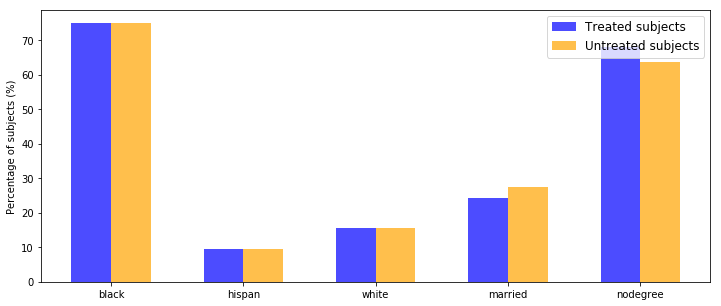

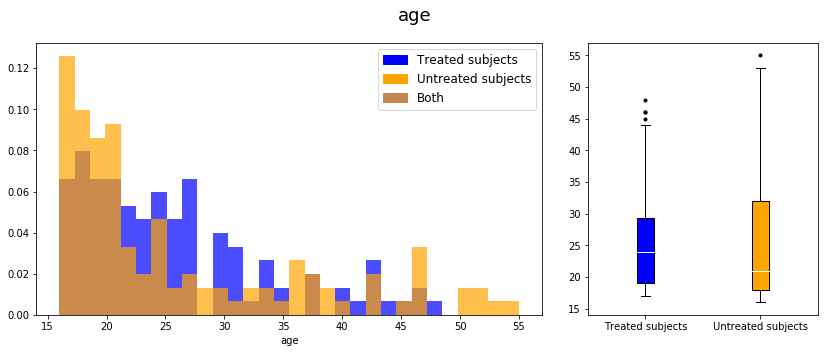

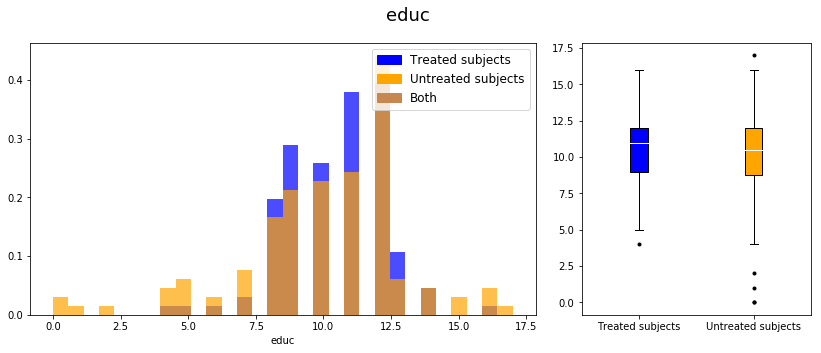

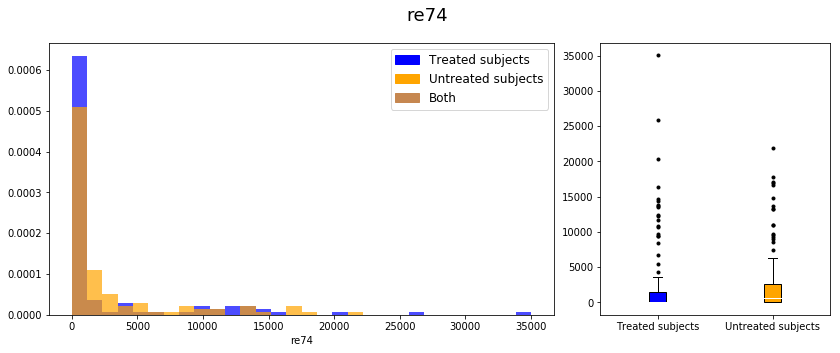

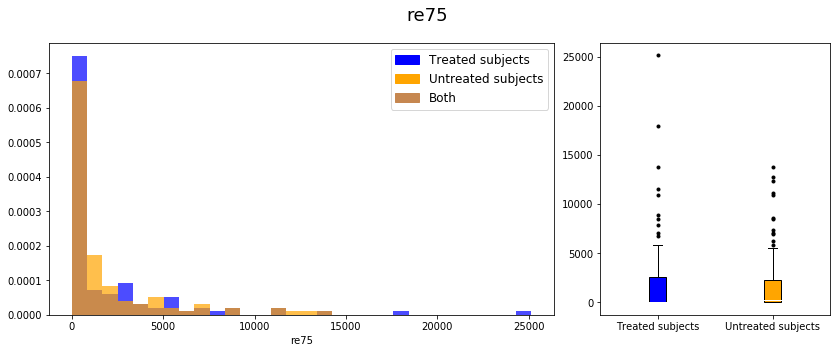

In [80]:
plot_binary_features(matched)

for col in cts_features:
    plot_feature_hist(col, matched)

## 6. A less naive analysis

# Question 2: Applied ML

In [25]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
newsgroups_train = fetch_20newsgroups(subset='train')

In [26]:
def split_data(x, y, ratio):
    '''
        split the dataset based on the split ratio. If ratio is 0.8,
        you will have 80% of your data set dedicated to training
        and the rest dedicated to testing
    '''
    random_uniform_vector = np.random.rand(x.shape[0])
    spliter = random_uniform_vector < ratio
    return (x[spliter == True], y[spliter == True]), (x[spliter == False], y[spliter == False])

We compute the TF-IDF features of each post. Then we create 3 datasets that are used for our analysis.
The train dataset is used to train our model.
The validation dataset is used to find optimal hyperparameters.
The test dataset is used at the end to confirm that our model is coherent.

In [27]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(newsgroups_train["data"])

(train_X, train_Y), (other_X, other_Y)  = split_data(X, newsgroups_train["target"], 0.8)
(validation_X, validation_Y), (test_X, test_Y) = split_data(other_X, other_Y, 0.5)

In [28]:
best_accuracy = 0.
best_n_est = 1
best_max_dep = 1
best_classifier = None

for n_est in range(5, 120, 10):
    for max_dep in range(20, 200, 20):
        classifier = RandomForestClassifier(n_estimators=n_est, max_depth=max_dep, n_jobs=-1)
        classifier.fit(train_X, train_Y)

        prediction = classifier.predict(validation_X)
        accuracy = accuracy_score(validation_Y, prediction)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_est = n_est
            best_max_dep = max_dep
            best_classifier = classifier

best accuracy : 0.8094405594405595
best accuracy : 0.8173076923076923
best accuracy : 0.8312937062937062


KeyboardInterrupt: 

When we use the test dataset to compute the confusion matrix, we see that most of the values are classified correctly.
Most of our errors are predicting talk.religion.misk instead of soc.religion.christian. This is due to the closeness of the two categories. 
Since we used our test dataset to assess our model, we can confirm that our model works on new data.

In [ ]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    plt.rcParams["axes.grid"] = False
    plt.figure(figsize=(20, 20))
    
    plt.imshow(cm, cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    legend_marks = np.arange(len(classes))
    plt.xticks(legend_marks, classes, fontsize=16, rotation=90)
    plt.yticks(legend_marks, classes, fontsize=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=16)

test_prediction = best_classifier.predict(test_X)
        
plot_confusion_matrix(confusion_matrix(test_prediction, test_Y), newsgroups_train.target_names)
print("Accuracy on test data : %s" % accuracy_score(test_prediction, test_Y))

Here we see that the importance of most feature is 0. This can be explaned by the fact that most word cannot be used to determine the 
Then only a little fraction of the remaining importances is big (shown in the graph).
We can see that the importance decays really quickly and only a little fraction of the words are really important in the categorisation.

In [ ]:
non_zero_importance_count = np.count_nonzero(best_classifier.feature_importances_)
zero_importance_count = best_classifier.feature_importances_.shape[0] - non_zero_importance_count

print("non zero importance count : %s" % non_zero_importance_count)
print("zero importance count : %s" % zero_importance_count)

non_zero_indices = np.nonzero(best_classifier.feature_importances_)
sorted_indices = np.argsort(best_classifier.feature_importances_[non_zero_indices])[::-1]

useful_words = np.array(vectorizer.get_feature_names())[non_zero_indices]
sorted_useful_words = useful_words[sorted_indices]

sorted_feature_importance = best_classifier.feature_importances_[non_zero_indices][sorted_indices]

plt.figure(figsize=(20,10))
plt.xlabel('n\'th most important word', fontsize=20)
plt.ylabel('Word importance', fontsize=20)
plt.plot(range(non_zero_importance_count), sorted_feature_importance)
plt.loglog()
plt.show()

Below we print the 50 most important word to determine the category and their coresponding feature_importance.
It makes sens that Words like windows, car, god and so on are really important to determine the category of the post.
Some word (of, in, is) are a bit more surprising because one would think that each category are independent of their occurences but apperently this is not the case.

In [ ]:
def plot_feature_importance(words_with_importance, n):
    """
    This function plots the word importance of the n most important word.
    """
    plt.figure(figsize=(20, 10))
    plt.xticks(np.arange(n), words_with_importance[0:n,0], fontsize=16, rotation=90)
    plt.ylabel('Word importance', fontsize=20)
    plt.bar(np.arange(n), words_with_importance[0:n, 1])
    
    
plot_feature_importance(np.array([sorted_useful_words, sorted_feature_importance]).T, 50)